In [113]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

from datetime import datetime
import json
from collections import defaultdict

import os

In [114]:
# OUT_DIR = '/mnt/swordfish-pool2/ndeas/prob_models/results/' #'/burg/nlp/users/zfh2000/style_results'

# DATA_SRC = '/mnt/swordfish-pool2/ndeas/prob_models/data/enron_processed.json' #'/burg/nlp/users/zfh2000/enron_processed.json'
# SPLITS_PATH = '/mnt/swordfish-pool2/ndeas/prob_models/data/authors_splits.json' #'/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
# SYNTHETIC_SRC = '/mnt/swordfish-pool2/ndeas/prob_models/data/gpt_4_enron_processed.json' #'/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

OUT_DIR = '/burg/nlp/users/zfh2000/style_results'

DATA_SRC = '/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH = '/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

# NICK: files have been uploaded here: https://drive.google.com/drive/folders/1uF9GWEGe4aqSeo2MlachAWR9bTHsJq1q?usp=sharing
# ['formality','irony', 'sentences', 'punc_tags', 'pos_bigrams', 'morph_tags', 'pos', 'casing', 'question',  'passive', 'emotion_task', 'sentiment_task', 'emoji_task']
# NICK: Unsure which of of these features we should include!

META_FEATURES = ['pos_bigrams'] # formality, casing, emoji, punctuation
EXPERIMENT_NAME = '_'.join(META_FEATURES)

BATCH_SIZE = 128
NUM_WORKERS = 2 #8

LR = 1e-2
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

DEVICE = torch.device('cuda:0')

NUM_TOPICS = 10 #10 #20 # NICK totally subject to changes
NUM_STYLES = 5  #20
HIDDEN_DIM = 64
DROPOUT    = 0 #0.2

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALE = 1.

KAPPA_PRIOR_DIST = 'gaussian' #'laplace'
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALE = 5 #10 #1.

STYLE_TOPIC_LINK = 'none' #'kappa_doc' #'none'

NUM_EPOCHS = 5 #100

MAX_DF=0.7
MIN_DF=20

date = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
info = {
    'experiment_name': EXPERIMENT_NAME,
    'num_topics': NUM_TOPICS,
    'num_styles': NUM_STYLES,
    'hidden_dim': HIDDEN_DIM,
    'dropout': DROPOUT,
    'theta_prior_dist': THETA_PRIOR_DIST,
    'theta_prior_loc': THETA_PRIOR_LOC,
    'theta_prior_scale': THETA_PRIOR_SCALE,
    'kappa_prior_dist': KAPPA_PRIOR_DIST,
    'kappa_prior_loc': KAPPA_PRIOR_LOC,
    'kappa_prior_scale': KAPPA_PRIOR_SCALE,
    'style_topic_link': STYLE_TOPIC_LINK,
    'num_epochs': NUM_EPOCHS,
    'date': date,
    'lr': LR,
    'betas': BETAS,
    'eps': EPS,
    'batch_size': BATCH_SIZE,
    'clip_norm': CLIP_NORM,
    'num_workers': NUM_WORKERS,
    'device': DEVICE.type,
    'meta_features': META_FEATURES,
    'DATA_SRC': DATA_SRC,
    'SPLITS_PATH': SPLITS_PATH,
    'SYNTHETIC_SRC': SYNTHETIC_SRC,
    'MAX_DF': MAX_DF,
    'MIN_DF': MIN_DF,

}
PATH = os.path.join(OUT_DIR, EXPERIMENT_NAME, date)
os.makedirs(PATH, exist_ok=True)
with open(os.path.join(PATH, 'info.json'), 'w') as f:
    json.dump(info, f, indent=4)

DATA_DIR_PATH = os.path.join(OUT_DIR,EXPERIMENT_NAME, f'maxdf{MAX_DF}_mindf{MIN_DF}_DATA')


# Data Setup 

## Data Processing 

In [115]:
import json
import pickle
from preprocess import clean_up_features, get_possible_values, extract_features

if not os.path.exists(DATA_DIR_PATH):
    with open(DATA_SRC, 'r') as in_file:
        data = json.load(in_file)
    
    with open(SYNTHETIC_SRC, 'r') as in_file:
       synthetic_data = json.load(in_file)
    
    # print(synthetic_data[:1])
    
    data = data + synthetic_data
    
    with open(SPLITS_PATH, 'r') as in_file:
        SPLITS = json.load(in_file)
    
    # data.head(2)
    for x in data:
        clean_up_features(x)
        
    print(data[:1])
    
    meta_feature_to_names = {}
    
    for key in META_FEATURES:
        meta_feature_to_names[key] = get_possible_values(data, key)
    
    extracted_features = [extract_features(d, meta_feature_to_names) for d in data]
    
    # extracted_features[2]
    
    training = []
    holdout = []

    author_labels = {'training':[], 'holdout':[]}

    raw_text = {'training':[], 'holdout':[]}
    
    authors = [d['info']['from'] for d in data]
    texts = [d['text'] for d in data]
    for author, t, d  in zip(authors, texts, extracted_features):
        if author.startswith('gpt') or author in SPLITS['train']:
            training.append(d)
            author_labels['training'].append(author)
            raw_text['training'].append(t)
            
    
        else:
            holdout.append(d)
            author_labels['holdout'].append(author)
            assert author in SPLITS['test']
            raw_text['holdout'].append(t)
    
    
    vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF, stop_words='english')
    vectorizer.fit([d['text'] for d in training])
    
    bows = {}

    meta_vectorized = {}
    
    for split_name, data_split in zip(['training','holdout'], [training, holdout]):
         bows[split_name] = vectorizer.transform([d['text'] for d in data_split])
         meta_vectorized[split_name] = {}
         for key in tqdm(sorted(data_split[0].keys())):
            if key in ['text']: continue
            meta_vectorized[split_name][key] = sparse.csr_matrix(np.stack([d[key] for d in data_split]))
            assert(bows[split_name].shape[0] == meta_vectorized[split_name][key].shape[0])

    os.makedirs(DATA_DIR_PATH, exist_ok=False)
    pickle.dump(vectorizer, open(os.path.join(DATA_DIR_PATH,"vectorizer.pickle"), "wb"))
    pickle.dump(bows, open(os.path.join(DATA_DIR_PATH,"bows.pickle"), "wb"))
    pickle.dump(meta_vectorized, open(os.path.join(DATA_DIR_PATH,"meta_vectorized.pickle"), "wb"))
    
    json.dump(raw_text, open(os.path.join(DATA_DIR_PATH,"raw_text.json"), "w"))
    json.dump(author_labels, open(os.path.join(DATA_DIR_PATH,"authors_json.json"), "w"))
    json.dump(meta_feature_to_names, open(os.path.join(DATA_DIR_PATH,"meta_feature_to_names.json"), "w"))
    
else:
    print(f"LOADING FROM {DATA_DIR_PATH}")
    with open(os.path.join(DATA_DIR_PATH, 'bows.pickle'), 'rb') as in_file:
        bows = pickle.load(in_file)
        
    with open(os.path.join(DATA_DIR_PATH, 'meta_vectorized.pickle'), 'rb') as in_file:
        meta_vectorized = pickle.load(in_file)    
    
    with open(os.path.join(DATA_DIR_PATH,"vectorizer.pickle"), 'rb') as in_file:
        vectorizer = pickle.load(in_file)
    

[{'text': 'Here is our forecast', 'info': {'author': 'allen-p', 'from': 'From: phillip.allen@enron.com', 'to': 'X-To: Tim Belden', 'cc': 'X-cc:', 'bcc': 'X-bcc:', 'meta': 'Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)'}, 'sentences': {'sentences:it-cleft': 0.0, 'sentences:pseudo-cleft': 0.0, 'sentences:all-cleft': 0.0, 'sentences:there-cleft': 0.0, 'sentences:if-because-cleft': 0.0, 'sentences:passive': 0.0, 'sentences:subj-relcl': 0.0, 'sentences:obj-relcl': 0.0, 'sentences:tag-question': 0.0, 'sentences:coordinate-clause': 0.0, 'none': 1}, 'passive': [0], 'formality': ['Formal'], 'pos': {'ADJ': 0, 'ADP': 0, 'ADV': 1, 'CONJ': 0, 'DET': 0, 'NOUN': 1, 'NUM': 0, 'PRT': 0, 'PRON': 1, 'VERB': 1, '.': 0, 'X': 0}, 'question': ['statement'], 'gram2vec': {'pos_unigrams:ADJ': 0.0, 'pos_unigrams:ADP': 0.0, 'pos_unigrams:ADV': 0.25, 'pos_unigrams:AUX': 0.25, 'pos_unigrams:CCONJ': 0.0, 'pos_unigrams:DET': 0.0, 'pos_unigrams:INTJ': 0.0, 'pos_unigrams:NOUN': 0.25, 'pos_unigrams:NUM': 0.0, 'pos_unigram

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.89it/s]


### Summary 

In [116]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}
IDX_TO_TERM = {v:k for k,v in vectorizer.vocabulary_.items()}

In [117]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 3098)
META Dims: {'pos_bigrams': 324}


## Dataset

In [118]:
from prodslda_cls import DocMetaData

In [119]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'])

In [120]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [121]:
test_ = next(iter(dl))
for k, v in test_.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print('\t'+k1, v1.shape)
    else:
        print(k, v.shape)
            
    # print(f'{k:7s}: {str(v.shape):25s} {str(v.dtype):25s}')

bow torch.Size([128, 3098])
meta
	pos_bigrams torch.Size([128, 324])


# Model Definition 

## ProdSLDA 

In [122]:
# from prodslda_cls import ProdSLDA

In [ ]:
class DocMetaData(Dataset):
    
    def __init__(self, bows, metas, dtype = np.float32):
        self.bows = bows
        self.metas = metas
        
        self.dtype = dtype
        
    def __len__(self):
        return self.bows.shape[0]
    
    def __getitem__(self, idx):
        
        bow = self.bows[idx].toarray().astype(self.dtype)[0]
        
        meta = {key:self.metas[key][idx].toarray().astype(self.dtype)[0] for key in self.metas}
        
        batch = {
            'bow': bow,
            'meta': meta,
        }
        
        return batch

class GeneralEncoder(nn.Module):
    
    def __init__(self, size_dict, num_styles, hidden, dropout, eps = 1e-10):
        super().__init__()
        
        self.eps = eps

        self.sizes = size_dict
        
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        
        # self.fc1_doc = nn.Linear(vocab_size, hidden)
        # self.fc1_meta = nn.Linear(meta_size, hidden)

        self.features = sorted(size_dict.keys())
        assert len(self.features) == 1
        # self.fc1s = nn.ModuleDict({feature:nn.Linear(self.sizes[feature], hidden) for feature in self.features})
        self.fc1s = nn.Linear(self.sizes[self.features[0]], hidden)
        self.fc2 = nn.Linear(len(self.features) * hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_styles)
        self.fclv = nn.Linear(hidden, num_styles)

        self.bnmu = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse

    def forward(self, inputs): #inputs_doc, inputs_meta):
        assert isinstance(inputs, dict)
        first_hiddens = []
        # for _, feature in enumerate(self.features):
        first_hiddens.append(F.relu(self.fc1s[self.features[0]](inputs[self.features[0]])))
        
        h = torch.hstack(first_hiddens)
        h = F.relu(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logkappa_loc = self.bnmu(self.fcmu(h))
        logkappa_logvar = self.bnlv(self.fclv(h))
        logkappa_scale = self.eps + (0.5 * logkappa_logvar).exp()  # Enforces positivity
        return logkappa_loc, logkappa_scale

class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return self.bn(self.beta(inputs))
    
class MetaDocDecoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, num_styles, dropout):
        super().__init__()
        self.t_beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.s_beta = nn.Linear(num_styles, vocab_size, bias=False)
        self.t_bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.s_bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs_doc, inputs_meta):
        inputs_doc  = self.drop(inputs_doc)
        inputs_meta = self.drop(inputs_meta)
        # the output is σ(βθ)
        
        dist_t = self.t_bn(self.t_beta(inputs_doc))
        dist_s = self.s_bn(self.s_beta(inputs_meta))
        
        return 0.5 * (dist_t + dist_s)

class ProdSLDA(nn.Module):
    
    PRIOR_DISTS  = {'gaussian': dist.Normal,
                    'laplace': dist.Laplace,
                   }
    TK_LINKS     = ('none', # Model style and documents independently
                    'kappa_doc', # Allow kappa to effect word distributions
                    'kappa_doc_style', # Allow kappa to effect word distributions and sampled words to effect style
                   )
    
    def __init__(self, vocab_size, meta_sizes, num_topics, num_styles, hidden, dropout, 
                 theta_prior_dist = 'gaussian', theta_prior_loc = 0., theta_prior_scale = 1.,
                 kappa_prior_dist = 'laplace', kappa_prior_loc = 0., kappa_prior_scale = 1.,
                 style_topic_link = 'none',
                 eps = 1e-10):
        super().__init__()
        
        # Global model variables
        self.vocab_size = vocab_size
        self.meta_sizes = meta_sizes
        self.num_topics = num_topics
        self.num_styles = num_styles
        self.hidden     = hidden
        self.dropout    = dropout

        self.meta_features = sorted(self.meta_sizes.keys())
        
        self.eps = eps
        
        # Theta Prior
        if theta_prior_dist not in ProdSLDA.PRIOR_DISTS.keys():
            raise ValueError(f'Theta prior {theta_prior_dist} not yet implemented. Must be one of {", ".join(ProdSLDA.PRIOR_DISTS.keys())}')
        self.theta_prior_dist = theta_prior_dist
        
        self.theta_prior_scale = theta_prior_scale
        self.theta_prior_loc = theta_prior_loc
        
        # Kappa Prior
        if kappa_prior_dist not in ProdSLDA.PRIOR_DISTS.keys():
            raise ValueError(f'Kappa prior {kappa_prior_dist} not yet implemented. Must be one of {", ".join(ProdSLDA.PRIOR_DISTS.keys())}')
        self.kappa_prior_dist = kappa_prior_dist
        
        self.kappa_prior_scale = kappa_prior_scale
        self.kappa_prior_loc = kappa_prior_loc
        
        
        # Document style linking
        self.style_topic_link = style_topic_link
        
        if self.style_topic_link not in ProdSLDA.TK_LINKS:
            raise ValueError(f'Link {self.style_topic_link} not yet implemented. Must be one of {", ".join(ProdSLDA.TK_LINKS)}')
        elif self.style_topic_link == 'none':
            # Independent modeling of style and topic, all normal encoder/decoders
            
            self.encoder = GeneralEncoder({'doc':vocab_size}, num_topics, hidden, dropout, self.eps)
            self.decoder = Decoder(vocab_size, num_topics, dropout)
            self.style_encoder = GeneralEncoder(meta_sizes, num_styles, hidden, dropout, self.eps)
            self.style_decoder = nn.ModuleDict({feature: Decoder(meta_s, num_styles, dropout) for feature, meta_s in meta_sizes.items()})
            
        elif self.style_topic_link == 'kappa_doc':
            # raise NotImplementedError()
            # Doc influences kappa encoding, style encoder takes in doc
            self.encoder = GeneralEncoder({'doc':vocab_size}, num_styles, hidden, dropout, self.eps)
            self.style_encoder = GeneralEncoder({'doc':vocab_size, **meta_sizes}, num_styles, hidden, dropout, self.eps)

            self.decoder = MetaDocDecoder(vocab_size=vocab_size, num_topics=num_topics, num_styles=num_styles, dropout=dropout)
            self.style_decoder = nn.ModuleDict({feature: Decoder(meta_s, num_styles, dropout) for feature, meta_s in meta_sizes.items()})


    def model(self, docs, metas):
        pyro.module("decoder", self.decoder)
        pyro.module("style_decoder", self.style_decoder)
        
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics)) * self.theta_prior_loc
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics)) * self.theta_prior_scale
            logkappa_loc = docs.new_zeros((docs.shape[0], self.num_styles)) * self.kappa_prior_loc
            logkappa_scale = docs.new_ones((docs.shape[0], self.num_styles)) * self.kappa_prior_scale
            
            # if self.style_topic_link == 'kappa_doc':
                # logtheta_s_loc = docs.new_zeros((docs.shape[0], self.num_topics)) * self.theta_prior_loc
                # logtheta_s_scale = docs.new_ones((docs.shape[0], self.num_topics)) * self.theta_prior_scale
                
                # logtheta_s = pyro.sample(
                    # "logtheta_s", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_s_loc, logtheta_s_scale).to_event(1))
                
                # theta_s = F.softmax(logtheta_s, -1)
            
            logtheta = pyro.sample(
                "logtheta", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_loc, logtheta_scale).to_event(1))
            logkappa = pyro.sample(
                "logkappa", ProdSLDA.PRIOR_DISTS[self.kappa_prior_dist](logkappa_loc, logkappa_scale).to_event(1))
            
            theta = F.softmax(logtheta, -1)
            kappa = F.softmax(logkappa, -1)

            if self.style_topic_link == 'none':
                word_logits = self.decoder(theta)
            elif self.style_topic_link == 'kappa_doc':
                word_logits = self.decoder(theta, kappa)
                
            style_logits = {feature:self.style_decoder[feature](kappa) for feature in self.meta_features}

            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs_doc',
                dist.Multinomial(total_count, logits = word_logits),
                obs=docs
            )

            # for feature in self.meta_features:
            #     total_s_count = int(metas[feature].sum(-1).max())
            #     pyro.sample(
            #         'obs_meta_'+feature,
            #         dist.Multinomial(total_s_count, logits = style_logits[feature]),
            #         obs=metas[feature]
            #     )

    def guide(self, docs, metas):
        pyro.module("encoder", self.encoder)
        pyro.module("style_encoder", self.style_encoder)
            
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            
            if self.style_topic_link == 'none':
                logtheta_loc, logtheta_scale = self.encoder({'doc':docs})
                logkappa_loc, logkappa_scale = self.style_encoder(metas)

            elif self.style_topic_link == 'kappa_doc':
                # raise NotImplementedError()
                # logtheta_loc, logtheta_scale, logkappa_d_loc, logkappa_d_scale = self.encoder({'doc':docs, **metas})
                logtheta_loc, logtheta_scale  = self.encoder({'doc':docs})
                logkappa_loc, logkappa_scale = self.style_encoder({'doc':docs, **metas})

                # NICK what was the point of d_loc and d_scale? Shoudln't we be generating one set of kappas from both features?
                
                # Average theta loc from document and style
                # logkappa_loc = 0.5 * (logkappa_loc + logkappa_d_loc) 
                # logkappa_scale = 0.5 * (logkappa_scale + logkappa_d_scale)
            
            # Sample logtheta/logkappa from guide
            logtheta = pyro.sample(
                "logtheta", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_loc, logtheta_scale).to_event(1))
            logkappa = pyro.sample(
                "logkappa", ProdSLDA.PRIOR_DISTS[self.kappa_prior_dist](logkappa_loc, logkappa_scale).to_event(1))

        # return logtheta, logkappa
            

    def beta_document(self):
        if self.style_topic_link == 'none':
            return {'beta_topic':self.decoder.beta.weight.cpu().detach().T}
        elif self.style_topic_link == 'kappa_doc':
            return {
                'beta_topic':self.decoder.t_beta.weight.cpu().detach().T,
                'beta_style':self.decoder.s_beta.weight.cpu().detach().T,
            }
        else:
            raise NotImplementedError()
            
    def beta_meta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        # return self.decoder.beta.weight.cpu().detach().T
        retval = {}
        for key, layer in self.style_decoder.items():
            retval[key] = layer.beta.weight.cpu().detach().T
        return retval
            
            

# Model Fitting 

In [ ]:
NUM_TOPICS = 20
# BATCH_SIZE = 
# NUM_STYLES = 2
# DROPOUT    = 0.
HIDDEN_DIM = 32
LR = 1e10

THETA_PRIOR_SCALE = 1
# KAPPA_PRIOR_SCALE = 3

CLIP_NORM = 1e10

## Setup

In [132]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())


{'beta_topic': tensor([[ 0.1728,  0.2147,  0.0582,  ..., -0.1210,  0.0876,  0.1361],
        [ 0.1905,  0.0670,  0.1940,  ...,  0.1566, -0.0453, -0.0014],
        [ 0.1763,  0.1895, -0.1289,  ..., -0.0864,  0.2122, -0.1905],
        ...,
        [-0.0557, -0.1346,  0.0220,  ..., -0.0825, -0.0639, -0.0241],
        [ 0.0623,  0.0225, -0.1864,  ..., -0.1321,  0.1941,  0.0331],
        [-0.1032,  0.1634, -0.1719,  ..., -0.0803, -0.1497, -0.2229]])}
{'pos_bigrams': tensor([[-0.0282, -0.3210, -0.0408,  ..., -0.4412,  0.2576,  0.3431],
        [ 0.0145,  0.2799,  0.2085,  ...,  0.0272,  0.4044, -0.2026],
        [-0.3757,  0.3128, -0.2860,  ..., -0.3508,  0.3782, -0.3976],
        [ 0.2708, -0.3604,  0.3101,  ..., -0.3844,  0.1634,  0.1410],
        [-0.4264,  0.0748, -0.2532,  ...,  0.2403, -0.1511,  0.3345]])}


## Training 

In [133]:
pyro.clear_param_store()
prod_slda.train()
print(DEVICE)
_

cuda:0


{'pos_bigrams': tensor([[-1.8304e+00, -1.8904e+00, -2.0618e+00,  ..., -1.5975e+00,
          -2.6415e+00, -1.9489e+00],
         [ 7.8684e-01,  1.0342e+00,  1.1435e+00,  ...,  1.0513e+00,
           1.1998e+00,  1.0992e+00],
         [ 8.8633e-01,  1.1214e+00,  1.3023e+00,  ...,  1.2147e+00,
           1.2440e+00,  1.1934e+00],
         [-4.2701e-01, -2.5076e-01, -3.2173e-01,  ..., -1.0346e-01,
          -5.0079e-01, -2.3791e-01],
         [-2.4423e-03,  1.2616e-01,  1.4202e-01,  ...,  2.4994e-01,
           1.5193e-02,  2.2705e-01]])}

In [134]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [135]:
print(pyro.poutine.trace(prod_slda.guide).get_trace(test_['bow'].to(DEVICE), {k:v.to(DEVICE) for k,v in test_['meta'].items()}).format_shapes())


                          Trace Shapes:            
                           Param Sites:            
              encoder$$$fc1s.doc.weight  32 3098   
                encoder$$$fc1s.doc.bias       32   
                   encoder$$$fc2.weight  32   32   
                     encoder$$$fc2.bias       32   
                  encoder$$$fcmu.weight  20   32   
                    encoder$$$fcmu.bias       20   
                  encoder$$$fclv.weight  20   32   
                    encoder$$$fclv.bias       20   
style_encoder$$$fc1s.pos_bigrams.weight  32  324   
  style_encoder$$$fc1s.pos_bigrams.bias       32   
             style_encoder$$$fc2.weight  32   32   
               style_encoder$$$fc2.bias       32   
            style_encoder$$$fcmu.weight   5   32   
              style_encoder$$$fcmu.bias        5   
            style_encoder$$$fclv.weight   5   32   
              style_encoder$$$fclv.bias        5   
                          Sample Sites:            
            

In [136]:
total_epochs = 0

In [137]:
NUM_EPOCHS = 50

In [ ]:
train_elbo = []
val_elbo = []

print("---TRAINING---")
for epoch in range(NUM_EPOCHS):
    
    epoch_elbo = 0.
    prod_slda.train()
    for batch in tqdm(dl):
        
        bow = batch['bow'].to(DEVICE)
        bop = {k:v.to(DEVICE) for k,v in batch['meta'].items()}
        
        epoch_elbo += svi.step(bow, bop)

    eval_elbo = 0
    prod_slda.eval()
    with torch.no_grad():
        for batch in tqdm(eval_dl):
            bow = batch['bow'].to(DEVICE)
            bop = {k:v.to(DEVICE) for k,v in batch['meta'].items()}
    
            # NICK: I think this may still be optimizing on holdout?
            eval_elbo += svi.evaluate_loss(bow, bop)
    
        
    print(f'Epoch {epoch}: {epoch_elbo:.3f}')
    print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')
    
    train_elbo.append(epoch_elbo)
    val_elbo.append(eval_elbo)
    total_epochs +=1

---TRAINING---


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:22<00:00,  8.11it/s]


Epoch 0: 6335.602
Epoch 0: Eval: 2070.445


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:16<00:00, 11.02it/s]


Epoch 1: 6189.974
Epoch 1: Eval: 2026.824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:10<00:00, 16.59it/s]


Epoch 2: 6081.159
Epoch 2: Eval: 2007.182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:15<00:00, 11.25it/s]


Epoch 3: 6048.905
Epoch 3: Eval: 1997.559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:11<00:00, 14.94it/s]


Epoch 4: 6039.785
Epoch 4: Eval: 1998.133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:09<00:00, 19.67it/s]


Epoch 5: 6039.180
Epoch 5: Eval: 1997.353


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:13<00:00, 13.02it/s]


Epoch 6: 6035.003
Epoch 6: Eval: 1998.139


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:09<00:00, 19.38it/s]


Epoch 7: 6033.626
Epoch 7: Eval: 1995.750


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:08<00:00, 21.57it/s]


Epoch 8: 6033.291
Epoch 8: Eval: 1996.020


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:08<00:00, 21.30it/s]


Epoch 9: 6030.642
Epoch 9: Eval: 1995.559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:07<00:00, 24.14it/s]


Epoch 10: 6031.703
Epoch 10: Eval: 1995.790


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:08<00:00, 20.94it/s]


Epoch 11: 6030.449
Epoch 11: Eval: 1994.444


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:11<00:00, 15.51it/s]


Epoch 12: 6029.111
Epoch 12: Eval: 1996.274


 28%|███████████████████████████▋                                                                      | 147/521 [00:08<00:08, 42.84it/s]

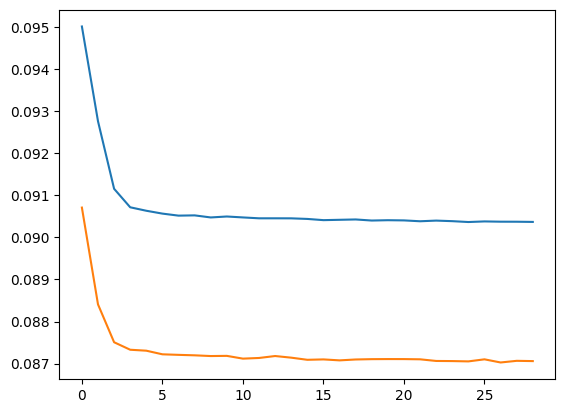

In [543]:
plt.plot(range(len(train_elbo)), [e/len(dl.dataset) for e in train_elbo])
plt.plot(range(len(val_elbo)), [e/len(eval_dl.dataset) for e in val_elbo])

plt.show()

# Examine Topics 

In [544]:
tbeta = prod_slda.beta_document()['beta_topic']

In [545]:
top_terms = (-tbeta).sort().indices[:,:10].numpy()
top_weights = -(-tbeta).sort().values[:,:10]

In [546]:
top_weights

tensor([[-2.1217, -2.1740, -2.2175, -2.2197, -2.2307, -2.2520, -2.2545, -2.2796,
         -2.2939, -2.3109],
        [ 1.7339,  1.6954,  1.6844,  1.6297,  1.6185,  1.5475,  1.5026,  1.4974,
          1.4937,  1.4849],
        [ 0.7961,  0.5104,  0.4615,  0.3790,  0.3368,  0.2915,  0.2889,  0.2520,
          0.1922,  0.1887],
        [ 0.2463,  0.2086,  0.1662,  0.1149,  0.1054,  0.1006,  0.0962,  0.0273,
          0.0064,  0.0053],
        [ 1.5790,  1.5733,  1.5476,  1.5344,  1.5073,  1.5060,  1.4974,  1.4901,
          1.4753,  1.4732],
        [ 1.9598,  1.9237,  1.8618,  1.7630,  1.7442,  1.7156,  1.7027,  1.6913,
          1.6764,  1.6728],
        [-0.0545, -0.0759, -0.1108, -0.1169, -0.1391, -0.1554, -0.1726, -0.1836,
         -0.1848, -0.1884],
        [ 0.5430, -0.1229, -0.1594, -0.2012, -0.2028, -0.2153, -0.2283, -0.2347,
         -0.2373, -0.2547],
        [ 0.8899,  0.8130,  0.7263,  0.6984,  0.6883,  0.6879,  0.6877,  0.6765,
          0.6506,  0.6380],
        [ 0.6902,  

In [547]:
top_words = defaultdict(list)
for i, term_l in enumerate(top_terms):
    top_words['topic ' + str(i)] = [IDX_TO_TERM[term_id] for term_id in term_l]

In [548]:
pd.DataFrame(top_words).T

,0,1,2,3,4,5,6,7,8,9
topic 0,blackberry,number,info,fine,www,08,01,lynn,464,deal
topic 1,good,sorry,50,contract,morning,just,following,probably,know,regards
topic 2,ll,pm,send,today,03,home,susan,10,amy,xls
topic 3,need,mike,received,tonight,great,hi,let,said,meeting,way
topic 4,try,intervention,monday,start,713,like,highlighted,download,donna,853
topic 5,asap,credit,task,people,piece,st,sure,power,don,updated
topic 6,guy,use,weather,28,jason,contact,review,ll,distribution,going
topic 7,going,report,power,explorer,28,home,mail,msn,time,tonight
topic 8,final,assistance,fyi,right,just,new,does,thank,tell,free
topic 9,mail,sure,99,sent,delainey,attached,read,going,questions,things


In [549]:
idx_1 = vectorizer.vocabulary_['paper']
idx_2 = vectorizer.vocabulary_['regards']

In [550]:
(bows['training'][:, idx_1] >= 1).sum(), (bows['training'][:, idx_2] >= 1).sum()

(113, 1079)

In [551]:
((bows['training'][:, idx_1] + bows['training'][:, idx_2]).toarray().squeeze() >= 2).sum()

9

In [377]:
def top_beta_document(model, vectorizer, top_k=20):
    betas_document = model.beta_document()
    features_to_betas = {}
    idx_to_name = {v:k for k,v in vectorizer.vocabulary_.items()}
    for feature, logits in betas_document.items():
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, top_k, dim=-1)
        
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
                
    return features_to_betas

def top_beta_meta(model, meta_feature_to_names, top_k=20):
    betas_metas = model.beta_meta()
    features_to_betas = {}
    for feature, logits in betas_metas.items():
        idx_to_name = {i:k for i,k in enumerate(meta_feature_to_names[feature])}
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, top_k, dim=-1)
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
        
    return features_to_betas 

In [378]:
top_words_per_latent = top_beta_document(prod_slda, vectorizer,  top_k=20)
top_meta_per_latent = top_beta_meta(prod_slda, meta_feature_to_names, top_k=20)

print('Document Term Info')
for latent, top in top_words_per_latent.items():
    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

print('Meta Var Info')
for latent, top in top_meta_per_latent.items():

    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

100%|██████████| 2/2 [00:00<00:00, 12052.60it/s]

Document Term Info
	beta_topic (5):
		 beta_topic (0):
['tired', 'comfortable', 'peters', 'blair', 'try', 'usual', 'time', 'historical', 'christopher', 'bike', 'quality', 'anytime', 'wear', 'facilities', 'issues', 'uk', 'returned', 'recipients', '20', 'benjamin']

		 beta_topic (1):
['change', 'gcp_enron', 'mona', 'wear', 'duty', 'worried', '916', 'young', 'returned', 'mailing', 'source', 'worry', 'nominations', 'internally', 'referenced', 'hasn', 'network', 'program', 'messaging', 'auto']

		 beta_topic (2):
['let', 'know', '20', 'need', 'america', 'kitchen', 'oct', 'mike', 'agreements', 'try', 'want', 'does', 'date', 'attached', 'make', '54', 'cc', 'bring', 'trading', 'job']

		 beta_topic (3):
['send', 'assume', 'mary', 'fine', 'ed', 'plant', '18', 'phone', 'asst', '30th', 'chance', '30', '01', 'originally', 'volumes', 'prebon', 'appreciate', 'somebody', 'ferc', 'hourahead']

		 beta_topic (4):
['haven', 'regards', 'weekend', 'hello', 'leave', 'home', 'comments', 'rick', 'considered

In [27]:
for key, value in prod_slda.beta_meta().items():
    print(key, F.softmax(value,-1))

pos_bigrams tensor([[0.0031, 0.0031, 0.0028,  ..., 0.0043, 0.0032, 0.0028],
        [0.0031, 0.0037, 0.0031,  ..., 0.0047, 0.0034, 0.0025],
        [0.0031, 0.0039, 0.0028,  ..., 0.0042, 0.0032, 0.0029],
        [0.0029, 0.0031, 0.0022,  ..., 0.0027, 0.0023, 0.0033],
        [0.0025, 0.0027, 0.0018,  ..., 0.0022, 0.0019, 0.0033]])


In [108]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
# pyro.clear_param_store()
# prod_slda = torch.load(path)
print(f'Saved to {path}')

Saved to /burg/nlp/users/zfh2000/style_results/pos_bigrams/2023-12-14_17_54_45/model_epoch5_20914.218841552734.pt


In [109]:
prod_slda.beta_meta()

{'pos_bigrams': tensor([[-1.8304e+00, -1.8904e+00, -2.0618e+00,  ..., -1.5975e+00,
          -2.6415e+00, -1.9489e+00],
         [ 7.8684e-01,  1.0342e+00,  1.1435e+00,  ...,  1.0513e+00,
           1.1998e+00,  1.0992e+00],
         [ 8.8633e-01,  1.1214e+00,  1.3023e+00,  ...,  1.2147e+00,
           1.2440e+00,  1.1934e+00],
         [-4.2701e-01, -2.5076e-01, -3.2173e-01,  ..., -1.0346e-01,
          -5.0079e-01, -2.3791e-01],
         [-2.4423e-03,  1.2616e-01,  1.4202e-01,  ...,  2.4994e-01,
           1.5193e-02,  2.2705e-01]])}